In [1]:
%matplotlib notebook

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
import skimage.io as io
from camera import take_picture
from eye_img import eye_img

In [4]:
class EyeModel(nn.Module):
    def __init__(self):
        super().__init__()
        # assumes 32x32
        self.conv1 = nn.Conv2d(1, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 7, 3)
        self.fc1 = nn.Linear(112, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #         x = F.softmax(self.fc1(x), dim=1)
        x = self.fc1(x)
        return x

In [5]:
model = torch.load("coolmodel.pb", map_location=torch.device('cpu'))

In [9]:
def user_interface():
    while True:
        choice = input("Upload (u) or take a photo (c)? ")
        if choice=="u":
            filepath = input("Filepath: ")
            pic = io.imread(str(filepath))
            break
        elif choice=="c":
            pic = take_picture()
            break
        else:
            print("Invalid input. Try again. ")
    return eye_img(pic, disp=True)

Upload (u) or take a photo (c)? u
Filepath: alan1.png


<IPython.core.display.Javascript object>


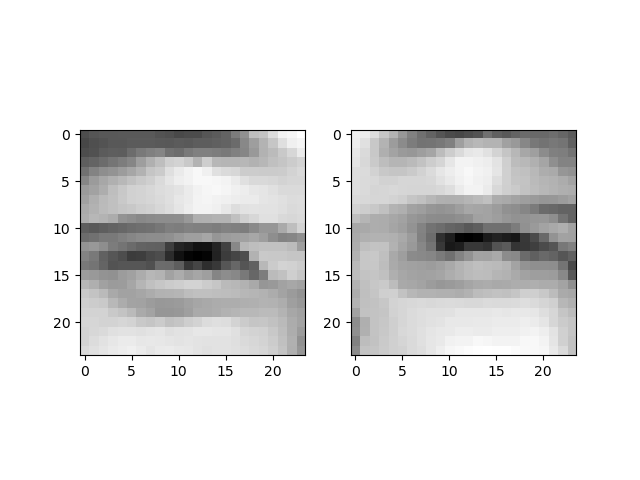

tensor([[ 0.0862, -0.6073]], grad_fn=<AddmmBackward0>) tensor([[-1.5801,  1.4588]], grad_fn=<AddmmBackward0>)
Left eye closed
Right eye open


In [29]:
left, right = user_interface()

left = torch.tensor(left).reshape(1,1,24,24).float()/255
right = torch.tensor(right).reshape(1,1,24,24).float()/255

print(model(left), model(right))

left = torch.argmax(model(left)).item()
right = torch.argmax(model(right)).item()

def printer(eyeopen):
    return "open" if eyeopen else "closed"

print("Left eye "+printer(left))
print("Right eye "+printer(right))